<a href="https://colab.research.google.com/github/luisjti/Ai/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from inspect import stack
import torch
import math
from matplotlib import pyplot as plt
import numpy as np

N = 400               # metade do numero total de amostras do dataset
NOISE = 10.0           # intensidade do ruido de coleta no dataset
SPLIT_RATIO = 0.5     # porcentagem de dados usados no dataset de treino
BATCH_SIZE = 10       # tamanho do batch usado durante o treinamento
LEARNING_RATE = 0.03  # taxa de aprendizado

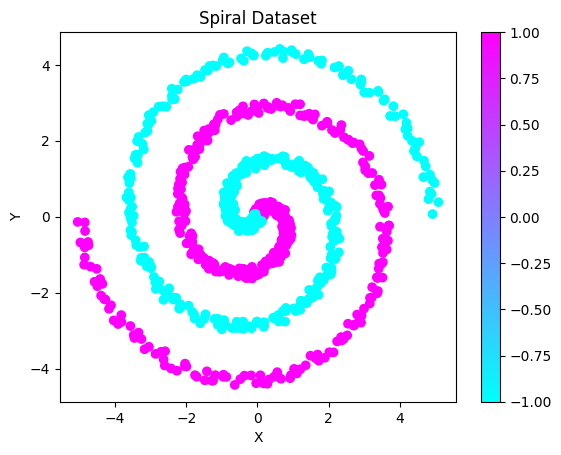

In [ ]:
def genSpiral(delta_t, label):
    r = 5*torch.linspace(0., 1., N+1)[:N]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    y = label*torch.ones_like(x0)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class SpiralDataset:
    def __init__(self):
        xp, yp = genSpiral(0, 1) # positive samples
        xn, yn = genSpiral(math.pi, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataset = SpiralDataset()

X = dataset.X.numpy()
Y = dataset.Y.numpy()

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='cool')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spiral Dataset')
plt.colorbar()
plt.show()

<ipython-input-2-4679dfc7c16f>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  x = torch.tensor([cx0, cx1]).T + x*(NOISE/25.)


1600


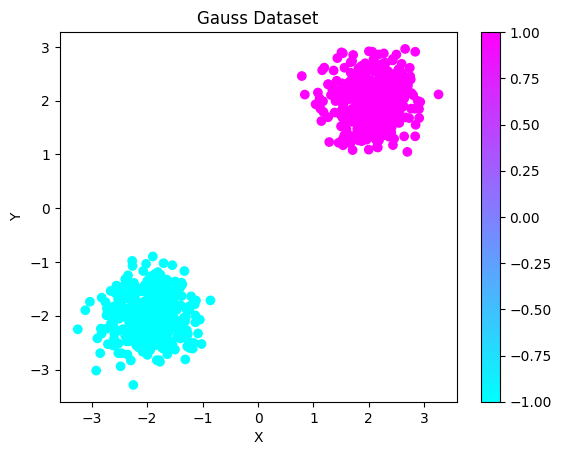

In [ ]:
def genGauss(cx0, cx1, label):
    x = torch.randn(N, 2)
    x = torch.tensor([cx0, cx1]).T + x*(NOISE/25.)
    y = label*torch.ones(N)
    return x, y

class GaussDataset:
    def __init__(self):
        xp, yp = genGauss(2, 2, 1) # positive samples
        xn, yn = genGauss(-2, -2, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

# TODO: plotar dataset gerado
dataset = GaussDataset()

X = dataset.X.numpy()
Y = dataset.Y.numpy()
print(X.size)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='cool')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gauss Dataset')
plt.colorbar()
plt.show()

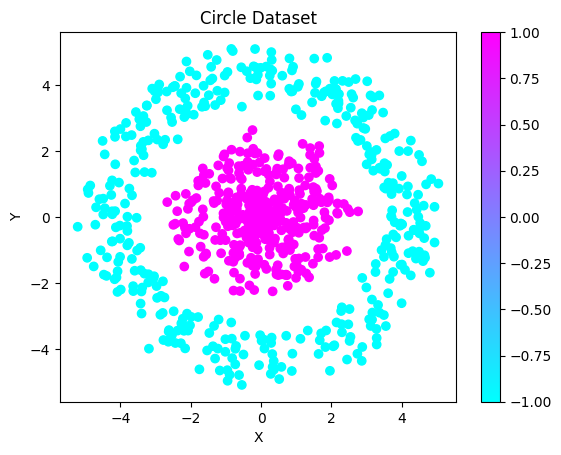

In [ ]:
def genCircle(r_min, r_max, label):
    r = (r_max - r_min)*torch.rand(N) + r_min
    angle = 2*math.pi*torch.rand(N)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    y = label*torch.ones_like(x0)
    return x, y

class CircleDataset:
    def __init__(self):
        xp, yp = genCircle(0, 2.5, 1) # positive samples
        xn, yn = genCircle(3.5, 5, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

# TODO: plotar dataset gerado
dataset = CircleDataset()

X = dataset.X.numpy()
Y = dataset.Y.numpy()

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='cool')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Circle Dataset')
plt.colorbar()
plt.show()

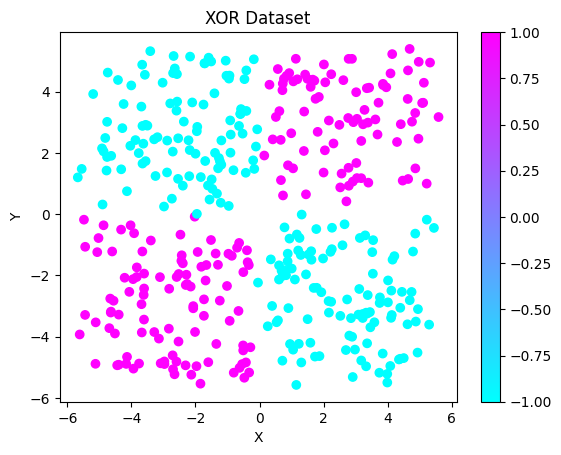

In [ ]:
def genXOR():
    x = 10.*torch.rand(N, 2) - 5.
    y = torch.sign(x[:,0]*x[:,1])
    padding = 0.3
    x += torch.sign(x)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class XORDataset:
    def __init__(self):
        self.X, self.Y = genXOR()

# TODO: plotar dataset gerado
dataset = XORDataset()

X = dataset.X.numpy()
Y = dataset.Y.numpy()
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='cool')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XOR Dataset')
plt.colorbar()
plt.show()

In [ ]:
# TODO
def train_test_split(dataset):
    total_samples = len(dataset.X)

    num_test_samples = int(SPLIT_RATIO * total_samples)

    indices = torch.randperm(total_samples)

    train_indices = indices[:-num_test_samples]
    test_indices = indices[-num_test_samples:]

    train_X = dataset.X[train_indices]
    train_Y = dataset.Y[train_indices]
    test_X = dataset.X[test_indices]
    test_Y = dataset.Y[test_indices]

    return train_X, train_Y, test_X, test_Y


In [ ]:
# TODO
class Neuron:
    def __init__(self, input_size, layer_size):
        self.weights = torch.randn(layer_size, input_size)
        self.bias = torch.randn(layer_size,1)

    def inference(self, X):
        linearTransformation = torch.matmul(self.weights, X) + self.bias
        output = torch.sigmoid(linearTransformation)
        return (2*output - 1)
class Model:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_layer1 = Neuron(2, hidden_size)
        self.output_layer = Neuron(4, output_size)

    def inference(self, X):
        # Foward propagation
        Z1 = self.hidden_layer1.inference(X.T)
        Z2 = self.output_layer.inference(Z1)
        return Z1 , Z2

    def updateParams(self,dW2,db2,dW1,db1):
        self.output_layer.weights -= LEARNING_RATE * dW2
        self.output_layer.bias -= LEARNING_RATE * db2
        self.hidden_layer1.weights -= LEARNING_RATE * dW1
        self.hidden_layer1.bias -=  LEARNING_RATE * db1

    def getParams(self) :
        return self.output_layer.weights, self.output_layer.bias, self.hidden_layer1.weights, self.hidden_layer1.bias

In [ ]:
# TODO
def get_loss(y, y_hat):
    y =  y.unsqueeze(0)
    #loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
    loss = y_hat - y
    return loss

def get_average_loss(loss, batch):
    total_loss = torch.sum(loss)
    average_loss = total_loss / batch
    return average_loss

def getPredictions(Z2):
    positive = Z2 > 0
    negative = Z2 <= 0
    Z2[positive] = 1
    Z2[negative] = -1
    return Z2

def getAccuracy(predictions, Y):
    print(predictions, Y)
    return torch.sum(predictions == Y) / Y.size


In [ ]:
## TODO
def train_loop(model, X, Y, batch,num_epochs):
    train_losses = []
    train_epochs = []
    for epoch in range(num_epochs):
        Z1 , Z2 = model.inference(X)

        #gradients output layer
        loss = get_loss(Y, Z2)
        dW2 = 1/batch* torch.matmul(loss, Z1.T)
        db2 =   1/batch* torch.sum(loss)

        #gradients hidden_layer
        hl_gradient = torch.matmul(loss, Z2.T) * (Z1 * (1 - Z1))
        dW1 =  1/batch* torch.matmul(hl_gradient, X)
        db1 =  1/batch* torch.sum(hl_gradient)

        #update params
        model.updateParams(dW2,db2,dW1,db1)
        if(epoch % 10 == 0):
          print("Iteration: ", epoch)
          current_loss = get_average_loss(loss, batch)
          train_losses.append(current_loss)
          train_epochs.append(epoch)
          #print(loss)
          #predictions = getPredictions(Z2)
          #print(predictions)
          #print(loss)

        #print(getAccuracy(predictions, Y))

        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss}")
    params = model.getParams()
    #print(params)
    print
    plt.plot(train_epochs,train_losses)

# Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
# TODO: plotar as curvas de loss nos datasets de treino e test durante o treinamento

Iteration:  0
Iteration:  10
Iteration:  20
Iteration:  30
Iteration:  40
Iteration:  50
Iteration:  60
Iteration:  70
Iteration:  80
Iteration:  90
Iteration:  100
Iteration:  110
Iteration:  120
Iteration:  130
Iteration:  140
Iteration:  150
Iteration:  160
Iteration:  170
Iteration:  180
Iteration:  190


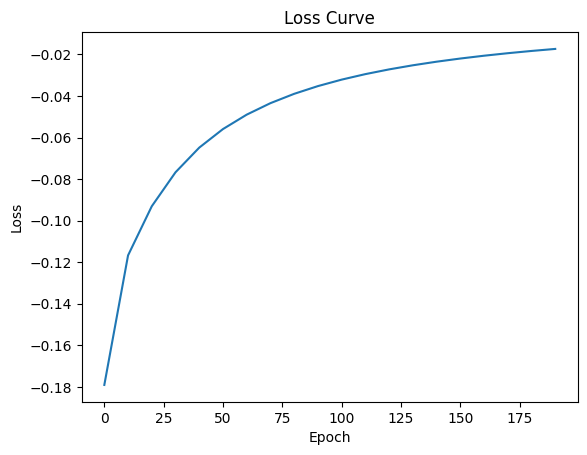

In [ ]:
# dica:
#torch.randperm(4)
#torch.rand(3)

# Create PyTorch tensors from the data
dataset = GaussDataset()
train_X, train_Y, test_X, test_Y = train_test_split(dataset)
model = Model(2, 4, 1)
train_loop(model, train_X, train_Y, 400, 200)
